---

In [2]:
import yfinance as yf
import pandas as pd 
import numpy as np
from datetime import date, timedelta
import plotly.graph_objects as go 
import random
import matplotlib.pyplot as plt
import statistics
from scipy import stats

# Ignore FutureWarning from yfinance
# warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
pd.options.mode.chained_assignment = None  # default='warn'


# Assuming you have the modified `moving_average` function
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
def moving_average(symbol, days_into_past): 
    DAYS_INTO_PAST = days_into_past
    STOCK_SYMBOLS = symbol 
    end_date = date.today() - timedelta(days=1)  # yesterday
    start_date = end_date - timedelta(days=DAYS_INTO_PAST)  # first date range

    ticker = yf.Ticker(ticker=STOCK_SYMBOLS)

    trading_df = ticker.history(
        period='1d', 
        start=start_date, 
        end=end_date
    )
    df = trading_df[['Open']]

    df.columns = [col.lower() for col in df.columns]
    # Create a 5-day moving average column
    df['short'] = df['open'].rolling(window=5).mean()

    # Create a 20-day moving average column
    # df['medium'] = df['open'].rolling(window=20).mean()

    # Create a 50-day moving average column
    df['long'] = df['open'].rolling(window=50).mean()

    # Plotly figure
    fig = go.Figure()

    # Plot the 'open' column
    fig.add_trace(go.Scatter(x=df.index, y=df['open'], mode='lines', name='Open'))

    # Plot the 5-day moving average
    fig.add_trace(go.Scatter(x=df.index, y=df['short'], mode='lines', name='5-day MA'))

    # # Plot the 20-day moving average
    # fig.add_trace(go.Scatter(x=df.index, y=df['medium'], mode='lines', name='20-day MA'))

    # Plot the 50-day moving average
    fig.add_trace(go.Scatter(x=df.index, y=df['long'], mode='lines', name='50-day MA'))

    # Identify the golden cross points (5-day MA crossing above 50-day MA from below)
    golden_cross_points = df[(df['short'] > df['long']) & (df['short'].shift(1) <= df['long'].shift(1))].index

    # Annotate the golden cross points with 'x'
    fig.add_trace(go.Scatter(x=golden_cross_points, y=df.loc[golden_cross_points, 'open'],
                            mode='markers', marker=dict(symbol='x', size=10, color='red'),
                            name='Golden Cross'))

    # Identify the sell signal points (20-day MA crossing below 50-day MA from above)
    sell_signal_points = df[(df['short'] < df['long']) & (df['short'].shift(1) >= df['long'].shift(1))].index

    # If the first ticker is a sell, ignore it
    if len(golden_cross_points) > 0 and len(sell_signal_points) > 0 and sell_signal_points[0] < golden_cross_points[0]:
        sell_signal_points = sell_signal_points[1:]

    # Annotate the sell signal points with 'x'
    fig.add_trace(go.Scatter(x=sell_signal_points, y=df.loc[sell_signal_points, 'open'],
                            mode='markers', marker=dict(symbol='x', size=10, color='black'),
                            name='Sell Signal'))

    # Connect buy and sell signals with arrows
    for buy_point, sell_point in zip(golden_cross_points, sell_signal_points):
        fig.add_trace(go.Scatter(x=[buy_point, sell_point], y=[df.loc[buy_point, 'open'], df.loc[sell_point, 'open']],
                                mode='lines', line=dict(color='blue', width=2), showlegend=False,
                                hoverinfo='none', opacity=0.7))

    # Update layout
    fig.update_layout(title=f'Stock Price with Moving Averages, Buy, and Sell Signals ({symbol})',
                    xaxis_title='Date',
                    yaxis_title='Price',
                    legend=dict(x=0, y=1, traceorder='normal'))

    # Show the plot
    fig.show()

    earnings_per_trade = []

    for buy_point, sell_point in zip(golden_cross_points, sell_signal_points):
        buy_price = df.loc[buy_point, 'open']
        sell_price = df.loc[sell_point, 'open']
        earnings_per_trade.append(sell_price - buy_price)
        print(f'Earnings for trade ({buy_point} to {sell_point}): {sell_price - buy_price}')

    # Calculate and print total earnings
    total_earnings = sum(earnings_per_trade)
    print(f'Total earnings: {total_earnings}')


In [4]:
ticker = 'BTC-USD'

In [5]:
input
moving_average(ticker, 1000)

Earnings for trade (2021-09-16 00:00:00+00:00 to 2021-09-22 00:00:00+00:00): -7480.953125
Earnings for trade (2021-10-05 00:00:00+00:00 to 2021-11-21 00:00:00+00:00): 10555.546875
Earnings for trade (2022-02-10 00:00:00+00:00 to 2022-02-21 00:00:00+00:00): -5924.58984375
Earnings for trade (2022-03-02 00:00:00+00:00 to 2022-03-08 00:00:00+00:00): -6297.71484375
Earnings for trade (2022-03-19 00:00:00+00:00 to 2022-04-13 00:00:00+00:00): -1671.078125
Earnings for trade (2022-07-23 00:00:00+00:00 to 2022-08-22 00:00:00+00:00): -1175.521484375
Earnings for trade (2022-10-27 00:00:00+00:00 to 2022-11-10 00:00:00+00:00): -4889.64453125
Earnings for trade (2023-01-08 00:00:00+00:00 to 2023-03-06 00:00:00+00:00): 5482.669921875
Earnings for trade (2023-03-16 00:00:00+00:00 to 2023-05-10 00:00:00+00:00): 3281.1796875
Earnings for trade (2023-06-22 00:00:00+00:00 to 2023-07-30 00:00:00+00:00): -638.841796875
Earnings for trade (2023-10-01 00:00:00+00:00 to 2024-01-17 00:00:00+00:00): 16164.7050

In [6]:
def moving_average_result(symbol, days_into_past): 
    DAYS_INTO_PAST = days_into_past
    STOCK_SYMBOLS = symbol 
    end_date = date.today() - timedelta(days=1)  # yesterday
    start_date = end_date - timedelta(days=DAYS_INTO_PAST)  # first date range

    ticker = yf.Ticker(ticker=STOCK_SYMBOLS)

    trading_df = ticker.history(
        period='1d', 
        start=start_date, 
        end=end_date
    )
    df = trading_df[['Open']]

    df.columns = [col.lower() for col in df.columns]
    # Create a 5-day moving average column
    df['short'] = df['open'].rolling(window=5).mean()

    # Create a 50-day moving average column
    df['long'] = df['open'].rolling(window=50).mean()

    # Identify the golden cross points (5-day MA crossing above 50-day MA from below)
    golden_cross_points = df[(df['short'] > df['long']) & (df['short'].shift(1) <= df['long'].shift(1))].index
    sell_signal_points = df[(df['short'] < df['long']) & (df['short'].shift(1) >= df['long'].shift(1))].index

    # If the first ticker is a sell, ignore it
    if len(golden_cross_points) > 0 and len(sell_signal_points) > 0 and sell_signal_points[0] < golden_cross_points[0]:
        sell_signal_points = sell_signal_points[1:]

    earnings_per_trade = []

    for buy_point, sell_point in zip(golden_cross_points, sell_signal_points):
        buy_price = df.loc[buy_point, 'open']
        sell_price = df.loc[sell_point, 'open']
        earnings_per_trade.append(sell_price - buy_price)

    # Calculate and print total earnings
    total_earnings = sum(earnings_per_trade)
    print(f'Total earnings: {total_earnings}')
    return total_earnings

In [7]:
# Checking the result
moving_average_result('BTC-USD', 1000)

Total earnings: 6798.4140625


6798.4140625

In [8]:
stock_ticker_df = pd.read_csv('stock_info.csv')
company_list = stock_ticker_df['Ticker'].to_list()
random_companies = random.sample(company_list, 30)

FileNotFoundError: [Errno 2] No such file or directory: 'stock_info.csv'

In [ ]:
average_list = []

for i in range(100):
    random_companies = random.sample(company_list, 30)
    earnings_list = []
    for company in random_companies:
        # calculate the earning for each company
        earnings = moving_average_result(company, 1000)
        earnings_list.append(earnings)
    average_list.append(np.mean(earnings_list))

average_list

DWCH: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Total earnings: 127.13997650146484
Total earnings: -32.778167001355314
Total earnings: 0
IDTI: No timezone found, symbol may be delisted
SHOR: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Total earnings: 0
Total earnings: 0
Total earnings: 0.06000018119812012
SFG: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Total earnings: 0.41658053425555064
Total earnings: -3.79000186920166
Total earnings: 0
IRE: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Total earnings: 0
CLUB: No timezone found, symbol may be delisted
Total earnings: 0
BMS: No price data found, symbol may be delisted (1d 2021-05-03 -> 2024-01-28)
Total earnings: 0
Total earnings: -21.329129095888547
Total earnings: -0.46000099182128906
Total earnings: -179.640014

[-3.863971702813266,
 -5.777710583127485,
 227.20862089618893,
 -0.31724626251505794,
 -8.479223426357512,
 -0.14005124325958096,
 -8.08907451097947,
 0.32073483947110615,
 -1.676273386357802,
 -10.54134044067884,
 -3.8643941527390044,
 -12.1853517214264,
 -6.395767096528834,
 -65.563049879409,
 -4.722921360163961,
 2.4821210606535513,
 -8.060596473511568,
 -5.698472719952216,
 -5.739842745809509,
 -4.085025893540382,
 336.87429244844145,
 -4.463206340918778,
 -4.923791056581011,
 -1.6731946203870778,
 -4.024903577007939,
 -2.4968793012252943,
 -0.5326147649474481,
 -6.718874593314027,
 -2.5854608706034936,
 0.8881438930145653,
 -4.424450032419005,
 -2.7318531761091256,
 -2.367517372429075,
 -3.5863895855788854,
 -7.009089078622716,
 -3.8608275603730764,
 0.24555720927575705,
 -5.252484377929467,
 -4.384029947483905,
 2.32033644061677,
 -2.268951390697138,
 -10.16243206142734,
 -10.710444298859029,
 -5.622398256675705,
 89.1516948068252,
 -0.6186012893857433,
 -10.942040760254049,
 -8.

In [ ]:
average_list

[-3.863971702813266,
 -5.777710583127485,
 227.20862089618893,
 -0.31724626251505794,
 -8.479223426357512,
 -0.14005124325958096,
 -8.08907451097947,
 0.32073483947110615,
 -1.676273386357802,
 -10.54134044067884,
 -3.8643941527390044,
 -12.1853517214264,
 -6.395767096528834,
 -65.563049879409,
 -4.722921360163961,
 2.4821210606535513,
 -8.060596473511568,
 -5.698472719952216,
 -5.739842745809509,
 -4.085025893540382,
 336.87429244844145,
 -4.463206340918778,
 -4.923791056581011,
 -1.6731946203870778,
 -4.024903577007939,
 -2.4968793012252943,
 -0.5326147649474481,
 -6.718874593314027,
 -2.5854608706034936,
 0.8881438930145653,
 -4.424450032419005,
 -2.7318531761091256,
 -2.367517372429075,
 -3.5863895855788854,
 -7.009089078622716,
 -3.8608275603730764,
 0.24555720927575705,
 -5.252484377929467,
 -4.384029947483905,
 2.32033644061677,
 -2.268951390697138,
 -10.16243206142734,
 -10.710444298859029,
 -5.622398256675705,
 89.1516948068252,
 -0.6186012893857433,
 -10.942040760254049,
 -8.

Average: 2.9807373257287186
Standard Deviation: 43.80453415767194


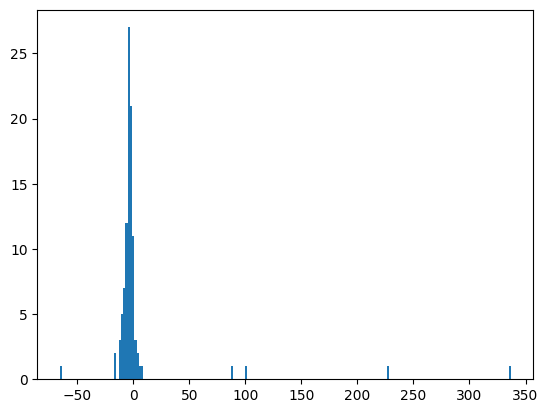

In [ ]:
plt.hist(average_list, bins= 200)
# Calculate the average
average = statistics.mean(average_list)

# Calculate the standard deviation
std_deviation = statistics.stdev(average_list)

print(f"Average: {average}")
print(f"Standard Deviation: {std_deviation}")

There's not enough evidence at alpha = 0.05 that the trading strategy returns a positive profit

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0664f050-994a-4a08-a162-495c5987b2a0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>